In [444]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split

In [191]:
# We run this to suppress various deprecation warnings from plotnine - keeps our notebook cleaner
import warnings
warnings.filterwarnings('ignore')


## Read in and do Further Cleaning

In [357]:
# Let's get some data
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')



In [358]:
test[test.isnull().any(axis=1)]

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2,Age,logPrice


In [359]:
train.drop(columns=['Unnamed: 0', 'Id'], inplace=True)
test.drop(columns=['Unnamed: 0', 'Id'], inplace=True)

In [360]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2,Age,logPrice
0,60,RL,65.0,8450,2,0.0,1,4,4,Inside,...,1,1,1,0,0,1,1,1,5,12.247694
1,20,RL,80.0,9600,2,0.0,1,4,4,FR2,...,1,1,0,0,0,0,1,1,31,12.109011
2,60,RL,68.0,11250,2,0.0,2,4,4,Inside,...,1,1,1,0,1,1,1,1,6,12.317167
3,70,RL,60.0,9550,2,0.0,2,4,4,Corner,...,1,1,1,0,1,0,1,0,36,11.849398
4,60,RL,84.0,14260,2,0.0,2,4,4,FR2,...,1,1,1,0,0,0,1,1,8,12.429216


## Investigation of Trends

### Neighborhood v Sale Price

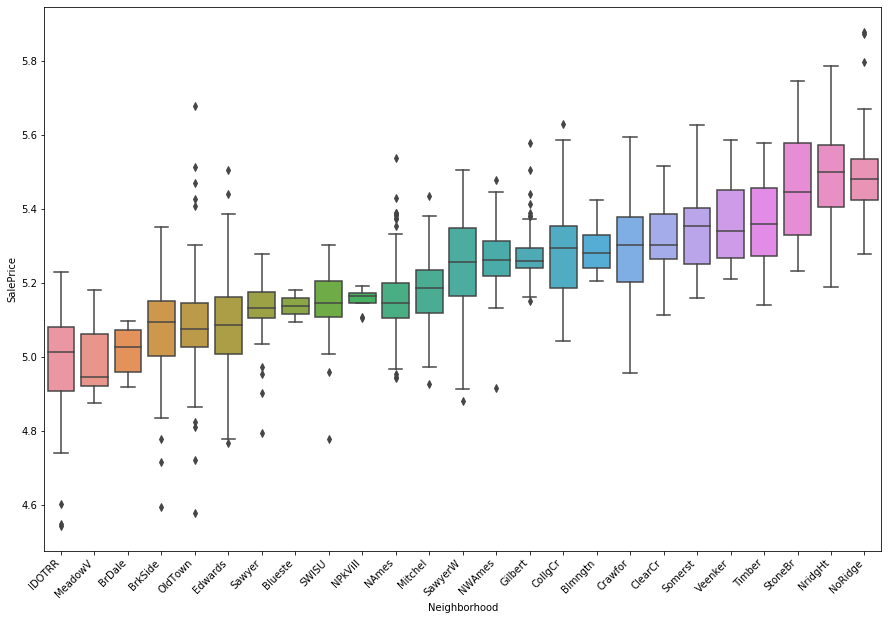

In [361]:
# Find the order
my_order = train.groupby(by=["Neighborhood"])["logPrice"].mean().sort_values().index
 
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="Neighborhood", y=np.log10(train['SalePrice']), data=train, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

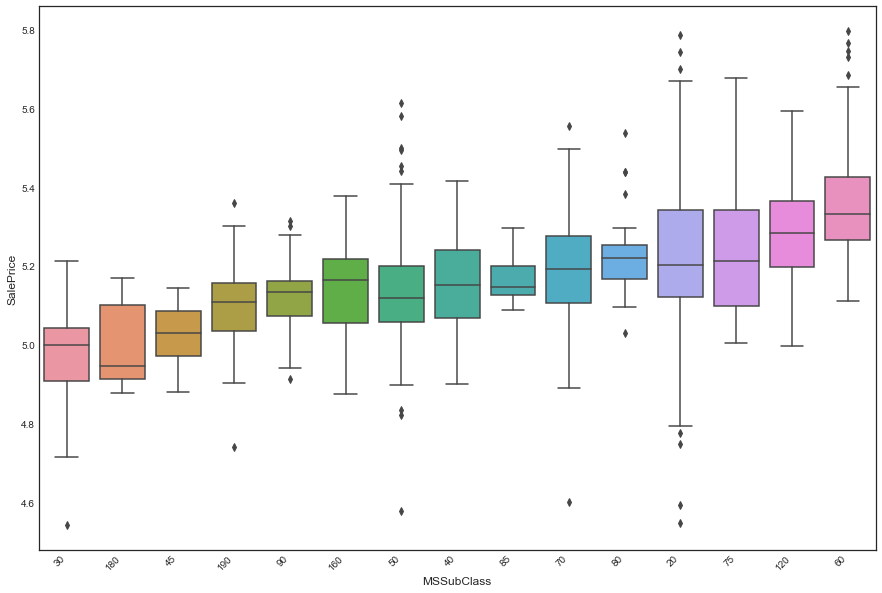

In [532]:
# Find the order
my_order = train.groupby(by=["MSSubClass"])["logPrice"].mean().sort_values().index
 
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="MSSubClass", y=np.log10(train['SalePrice']), data=train, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

It's clear location matters in the price of the home. While there are outliers, the sale price of a home can be roughly correlated with where it is in Ames. This led me to create a new feature called PriceRange that I would be able to segment a model by. 

In [362]:
train['BldgType'].unique()

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

### Let's visualize our new set and create some new columns

In [473]:
# Let's get some data
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')
#train['logPrice'] = np.log(train['SalePrice'])

In [474]:
hood_means = train.groupby(by=["Neighborhood",'MSZoning','OverallQual'])["logPrice"].mean().reset_index()
hood_means['PriceRange'] = pd.qcut(hood_means.logPrice,3,labels=['Low','Middle','High'])


In [475]:
hood_means

,Neighborhood,MSZoning,OverallQual,logPrice,PriceRange
0,Blmngtn,RL,7,12.142839,Middle
1,Blmngtn,RL,8,12.309824,High
2,Blmngtn,RM,7,12.093688,Middle
3,Blueste,RM,6,11.826536,Middle
4,BrDale,RM,5,11.668091,Low
...,...,...,...,...,...
146,Veenker,RL,5,12.233932,High
147,Veenker,RL,6,12.065002,Middle
148,Veenker,RL,7,12.591335,High
149,Veenker,RL,8,12.535243,High


In [449]:
print(train.shape)
print(test.shape)

(1456, 95)
(1459, 94)


In [476]:
train = train.merge(hood_means[['Neighborhood','PriceRange','MSZoning','OverallQual']], on = ['Neighborhood','MSZoning','OverallQual'])
test = test.merge(hood_means[['Neighborhood','PriceRange','MSZoning','OverallQual']], on = ['Neighborhood','MSZoning','OverallQual'], how='left')

In [477]:
print(train.shape)
print(test.shape)

(1456, 96)
(1459, 95)


In [478]:
test['PriceRange'] = test.PriceRange.fillna('Middle')

In [479]:
print(train.shape)
print(test.shape)

(1456, 96)
(1459, 95)


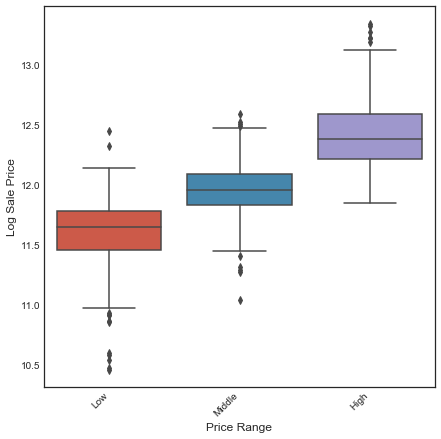

In [480]:
# Find the order
#my_order = train.groupby(by=["Neighborhood"])["SalePrice"].mean().sort_values().index
 
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="PriceRange", y='logPrice', data=train)#, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


ax.set(xlabel='Price Range', ylabel='Log Sale Price')
ax.figure.savefig("./presentation/price_range_box.svg",bbox_inches='tight')

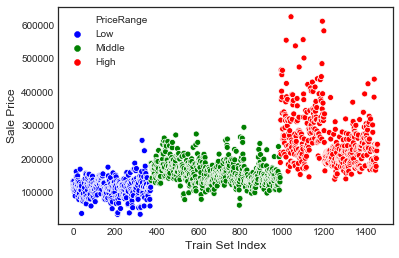

In [481]:
train.sort_values('PriceRange', inplace=True)
train.reset_index(drop=True, inplace=True)
ax = sns.scatterplot(x=range(len(train)), y = 'SalePrice', 
                     hue='PriceRange', 
                     palette=['Blue','Green','Red'],
                     data=train)

ax.set(xlabel='Train Set Index', ylabel='Sale Price')
ax.figure.savefig("./presentation/price_range.svg",bbox_inches='tight')



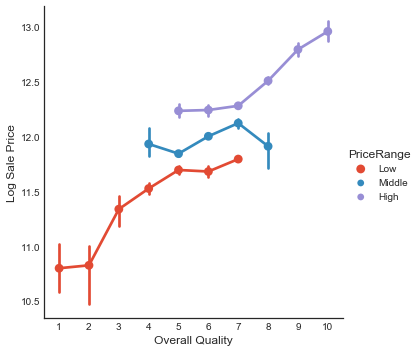

In [540]:
ax = sns.catplot(x="OverallQual", y="logPrice", hue="PriceRange", kind="point", data=train);


ax.set(xlabel='Overall Quality', ylabel='Log Sale Price')
ax.savefig("./presentation/seaborn/qual_v_logsale.svg",bbox_inches='tight')

In [ ]:
ax = sns.catplot(x="OverallQual", y="logPrice", hue="PriceRange", kind="point", data=train);


ax.set(xlabel='Overall Quality', ylabel='Sale Price')
#ax.savefig("./presentation/seaborn/qual_v_sale.svg",bbox_inches='tight')

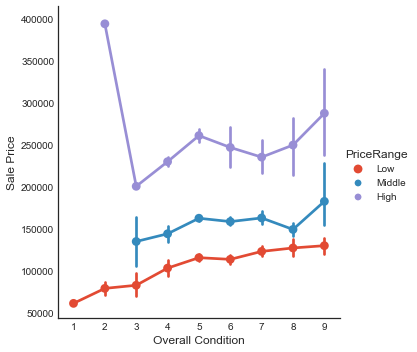

In [519]:
ax = sns.catplot(x="OverallCond", y="SalePrice", hue="PriceRange", kind="point", data=train);


ax.set(xlabel='Overall Condition', ylabel='Sale Price')
ax.savefig("./presentation/seaborn/cond_v_sale.svg",bbox_inches='tight')

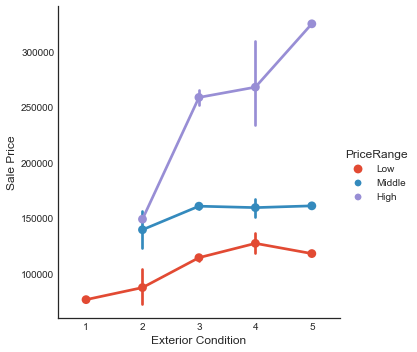

In [521]:
ax = sns.catplot(x="ExterCond", y="SalePrice", hue="PriceRange", kind="point", data=train);


ax.set(xlabel='Exterior Condition', ylabel='Sale Price')
ax.savefig("./presentation/seaborn/exter_v_sale.svg",bbox_inches='tight')

[Text(0, 0.5, 'Sale Price'), Text(0.5, 0, 'Exterior Condition')]

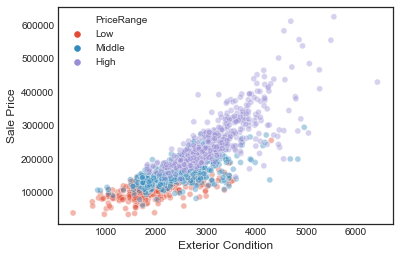

In [538]:
ax = sns.scatterplot(x="TotalSF", y="SalePrice", hue="PriceRange", data=train, alpha=0.4);


ax.set(xlabel='Exterior Condition', ylabel='Sale Price')
#ax.savefig("./presentation/seaborn/exter_v_sale.svg",bbox_inches='tight')

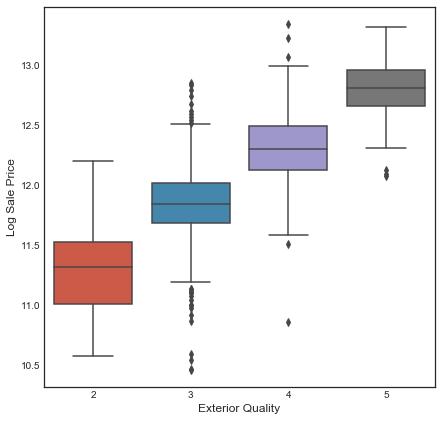

In [586]:
# Find the order
#my_order = train.groupby(by=["Neighborhood"])["SalePrice"].mean().sort_values().index
 
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="ExterQual", y='logPrice', data=train)#, order=my_order)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


ax.set(xlabel='Exterior Quality', ylabel='Log Sale Price')


ax.figure.savefig("./presentation/exterbox_v_logsale.svg",bbox_inches='tight')

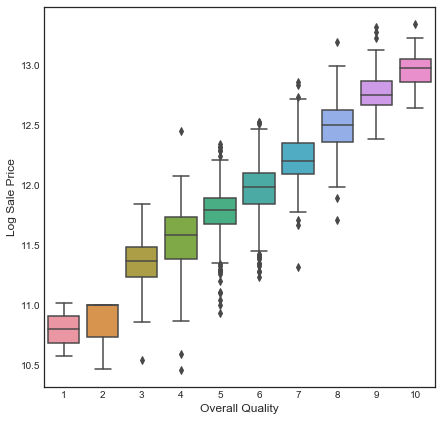

In [583]:
# Find the order
#my_order = train.groupby(by=["Neighborhood"])["SalePrice"].mean().sort_values().index
 
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="OverallQual", y='logPrice', data=train)#, order=my_order)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


ax.set(xlabel='Overall Quality', ylabel='Log Sale Price')


ax.figure.savefig("./presentation/qualbox_v_logsale.svg",bbox_inches='tight')

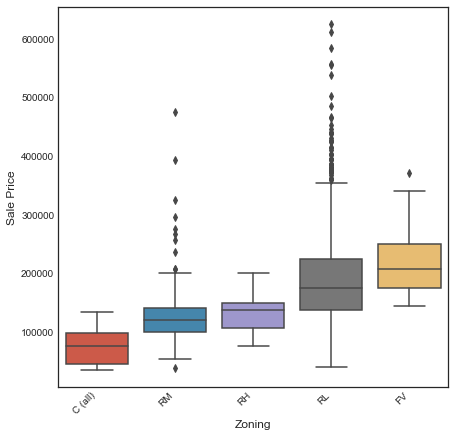

In [515]:
# Find the order
my_order = train.groupby(by=["MSZoning"])["SalePrice"].mean().sort_values().index

plt.figure(figsize=(7,7))
ax = sns.boxplot(x="MSZoning", y='SalePrice', data=train, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


ax.set(xlabel='Zoning', ylabel='Sale Price')

ax.figure.savefig("./presentation/zonebox_v_sale.svg",bbox_inches='tight')

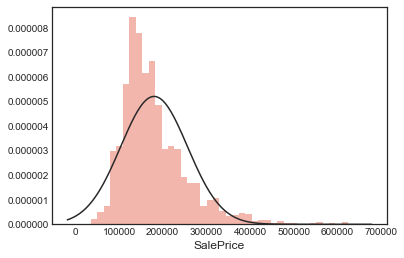

In [579]:
#from scipy.stats import norm
ax = sns.distplot(a=train.SalePrice, fit=norm, kde=False);

ax.figure.savefig("./presentation/seaborn/hist_saleprice.svg",bbox_inches='tight')

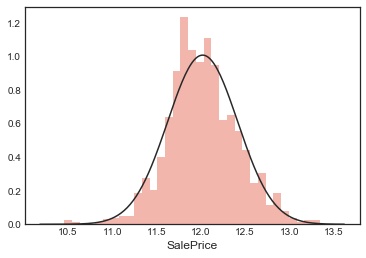

In [582]:
ax = sns.distplot(a=np.log(train.SalePrice), fit=norm, kde=False);


ax.figure.savefig("./presentation/seaborn/hist_logprice.svg",bbox_inches='tight')

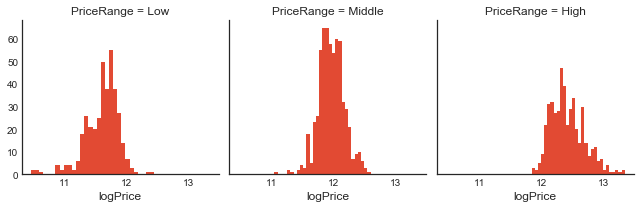

In [564]:
g = sns.FacetGrid(train, col="PriceRange", margin_titles=True)
g.map(plt.hist, "logPrice", bins=30)

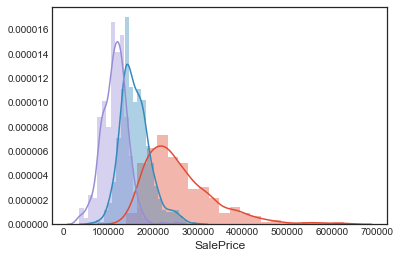

In [576]:
ax = sns.distplot(train[train.PriceRange == 'High']['SalePrice'])
sns.distplot(train[train.PriceRange == 'Middle']['SalePrice'])
sns.distplot(train[train.PriceRange == 'Low']['SalePrice']);
#sns.distplot(data['y']);

ax.figure.savefig("./presentation/seaborn/hist_price_range.svg",bbox_inches='tight')

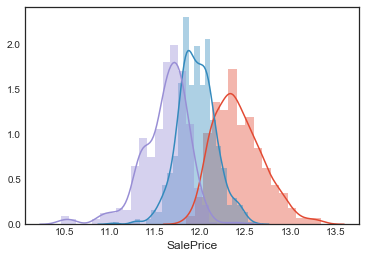

In [577]:

ax = sns.distplot(np.log(train[train.PriceRange == 'High']['SalePrice']))
sns.distplot(np.log(train[train.PriceRange == 'Middle']['SalePrice']))
sns.distplot(np.log(train[train.PriceRange == 'Low']['SalePrice']));


ax.figure.savefig("./presentation/seaborn/log_hist_price_range.svg",bbox_inches='tight')

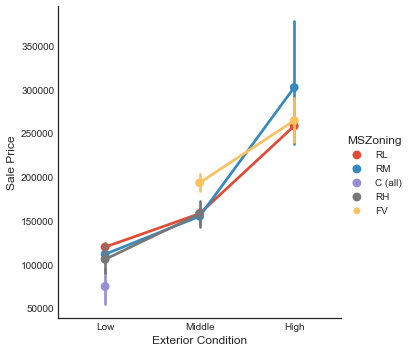

In [526]:
ax = sns.catplot(hue="MSZoning", y="SalePrice", x="PriceRange", kind="point", data=train);


ax.set(xlabel='Exterior Condition', ylabel='Sale Price')
#x.savefig("./presentation/seaborn/exter_v_sale.svg",bbox_inches='tight')

In [486]:
train.to_csv('./data/train_cleanest.csv')
test.to_csv('./data/test_cleanest.csv')

In [225]:
train.reset_index(drop=True, inplace=True)

In [167]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2,Age,logPrice,PriceRange
0,180,RM,21.0,1890,2,0.0,1,4,4,Inside,...,0,0,0,0,0,1,1,36,11.302204,Poor
1,20,RL,60.0,8070,2,0.0,1,4,4,Inside,...,0,0,0,1,0,1,1,12,11.724806,Poor
2,30,C (all),120.0,18000,1,0.0,1,1,4,Inside,...,1,1,0,1,0,1,0,58,11.302204,Poor
3,50,C (all),105.0,8470,2,0.0,2,4,4,Corner,...,0,1,0,1,0,1,0,27,11.350407,Poor
4,90,RM,60.0,7596,2,1.0,1,4,4,Inside,...,1,0,0,0,0,1,1,57,11.732061,Poor


### Exploration of Price Segmentation

In [13]:
# g = sns.pairplot(train[['GrLivArea','TotalBsmtSF','logPrice']], hue='PriceRange', kind='reg')
# g = g.map_diag(plt.hist)
# g = g.map_offdiag(plt.scatter)
# g = g.add_legend()

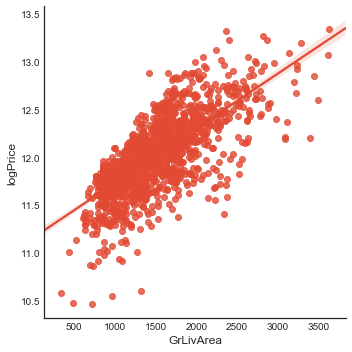

In [593]:
sns.lmplot(x="GrLivArea", y="logPrice",#hue="ExterQual",
           data=train);

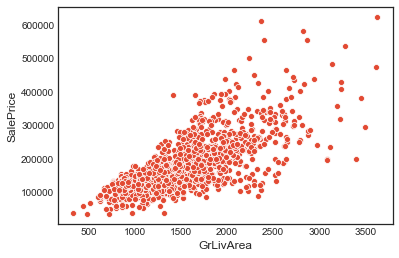

In [595]:
sns.scatterplot(x="GrLivArea", y="SalePrice",#hue="ExterQual",
           data=train);

Segmenting shows different linear regressions for TotalSF v SalePrice

In [96]:
# n_filter = 20
# num_points = train.groupby(by=["Neighborhood",'OverallQual']).size().reset_index()
# num_points = num_points[num_points[0] > n_filter].sort_values(by=0, ascending=False)

## Seaborn not as intuitive as ggplot for complex plotting
# plt.figure(figsize=(10,20))
# ax = sns.catplot(x="Neighborhood", y="OverallQual", 
#                  data=num_points, 
#                  palette=['black'], 
#                  height=3, aspect=4)
# for axes in ax.axes.flat:
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')
# plt.grid()  #just add this
# plt.show()

### Interaction between Neighborhood and Various Subjective Measures

In [344]:
hood_means = train.groupby(by=["Neighborhood",'TotalBathrooms','KitchenAbvGr','ExterQual','OverallQual','MSZoning'])["logPrice"].mean().reset_index()
hood_means['PriceRange'] = pd.qcut(hood_means.logPrice,5,labels=['Poor','LowerMiddle','Middle','UpperMiddle','Rich'])


In [97]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='./Linear Model/nQ.png'></td><td><img src='./Linear Model/nQ_test.png'></td></tr></table>"))

,


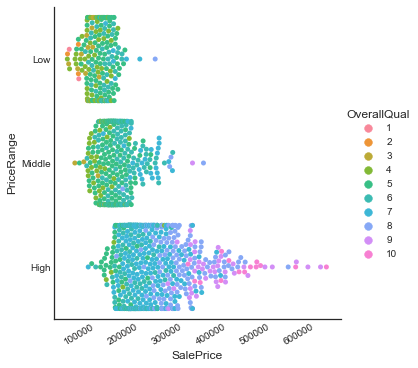

In [457]:
ax = sns.catplot(y="PriceRange", x="SalePrice", hue="OverallQual", kind='swarm',
           data=train);
for axes in ax.axes.flat:
     axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment='right')

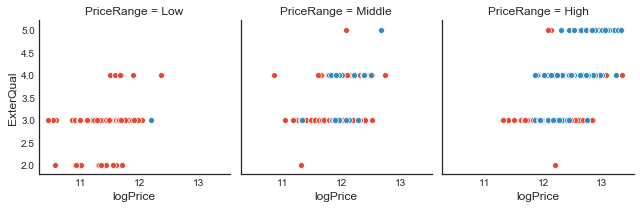

In [458]:

cond_plot = sns.FacetGrid(data=train, col='PriceRange', hue='IsNew', col_wrap=3)
cond_plot.map(sns.scatterplot, 'logPrice', 'ExterQual');

In [15]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='./Linear Model/nC.png'></td><td><img src='./Linear Model/nC_test.png'></td></tr></table>"))

,


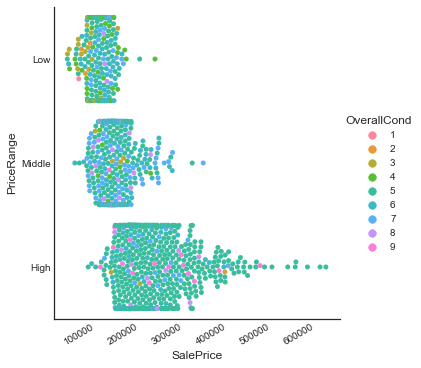

In [459]:
ax = sns.catplot(y="PriceRange", x="SalePrice", hue="OverallCond", kind='swarm',
           data=train);
for axes in ax.axes.flat:
     axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment='right')

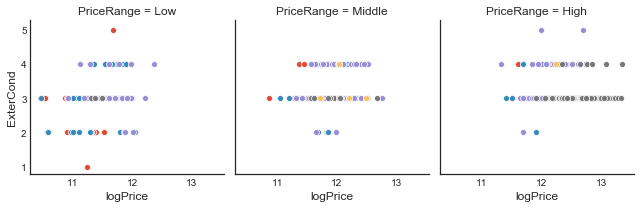

In [465]:
cond_plot = sns.FacetGrid(data=train, col='PriceRange', hue='GarageCars', col_wrap=3)
cond_plot.map(sns.scatterplot, 'logPrice', 'ExterCond');

### Hypothesized Interactions:

Interactions:
- 1st Floor SF and 2nd Floor SF
    - 1st Floor sets the physically boundaries of any potential 2nd floor
- Exterior Condition and Garage Quality
    - A well maintained garage is usually coupled with a well maintained exterior
- Neighborhood and Overall Condition
    - Good neighborhoods typically require homeowners to maintain appearance of their homes
    
    


### EDA Conclusion

There is some relationship between where a property is located and subjective measures like Overall Quality and Overall Condition. Overall Quality seems to be the more tightly coupled to price and by extension the segments we created. We will explore these interactions (among others) in the modeling sections to follow.

## Modeling GAMs

### Motivation

<img src="./Linear Model/three-lm-problems-1.png">

Three assumptions of the linear model (left side):
- Gaussian distribution of the outcome given the features
- Additivity (no interactions)
- Linear relationship between predictors and response. 

Reality usually does not adhere to those assumptions (right side): 

- Outcomes might have non-Gaussian distributions
- Features might interact
- Relationship might be nonlinear.

Main difference between linear and GAM models are that linear models assume a fixed linear or some other parametric form of the relationship between the dependent variable and the covariates. A GAM makes no such assumptions a priori of any specific form of this relationship, and - in fact - can be used to reveal and estimate non-linear effects of the covariate on the dependent variable. 

In linear models the linear predictor is a weighted sum of $n$ covariates.
In a GAM this term is replaced by a sum of smooth functions. 

By combining basis functions GAMs can represent a large number of functional relationship (to do so they rely on the assumption that the true relationship is likely to be smooth, rather than wiggly). 

Essentially an extension of GLMs, they are designed in a way that makes them particularly useful for uncovering nonlinear effects of numerical covariates, and for doing so in an "automatic" fashion [Hastie and Tibshirani original article], they have 'the advantage of being completely automatic, i.e. no "detective" work is needed on the part of the statistician.

### Data Preparation

In [17]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,TotalBathrooms,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2,PriceRange
0,60,RL,65.0,8450,2,0.0,1,4,4,Inside,...,3.5,1,1,1,0,0,1,1,1,UpperMiddle
1,60,RL,68.0,11250,2,0.0,2,4,4,Inside,...,3.5,1,1,1,0,1,1,1,1,UpperMiddle
2,20,RL,91.0,10652,2,0.0,2,4,4,Inside,...,2.0,1,1,1,0,1,1,0,1,UpperMiddle
3,20,RL,75.0,9742,2,0.0,1,4,4,Inside,...,2.0,1,1,1,0,0,1,1,1,UpperMiddle
4,20,RL,85.0,11049,2,0.0,1,4,4,Corner,...,2.0,1,1,1,0,0,1,1,1,UpperMiddle


In [18]:
train_dummy = pd.get_dummies(train,drop_first=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_dummy, train_dummy['SalePrice'], test_size=0.2, random_state=41)

In [20]:

from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)


In [21]:
X_inter = interaction.fit_transform(X_train)

In [22]:
from pygam import GAM, LinearGAM, s, f, te, l
#X = X_train[['GrLivArea','TotalBsmtSF','OverallQual']]
#X_t = X_test[['GrLivArea','TotalBsmtSF','OverallQual']]
y = np.log(y_train)
#y_t = np.log(y_test)



lams = np.random.rand(30, 3) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

gam = LinearGAM().fit(X_train, y_train)
gam.gridsearch(X_train, y_train)
#gam.summary()

 45% (5 of 11) |###########              | Elapsed Time: 0:03:38 ETA:   0:04:23

LinAlgError: SVD did not converge

In [541]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

ImportError: cannot import name '_to_object_array' from 'sklearn.utils' (/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py)

In [ ]:
print('Average Difference in Predicted Price: ${}'.format(round(np.sqrt(np.square(np.exp(gam.predict(X_t)) - y_test).mean()),2)))

In [ ]:
for i, term in enumerate(gam.terms):
    if term.isintercept or term.istensor:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

## Generalized Cross Validation

Provides a convenient approximation to leave one out CV for linear fitting under a squared error loss. S is the hat matrix

$$GCV(\hat{f}) = \frac{1}{N}\sum_{i=1} \left[\frac{y_i - \hat{f}(x_i)}{1-trace(S)/N}\right]^2$$

In smoothing problems, GCV can also alleviate tendency of cross validation to undersmooth. Has similarity to AIC from the approximation 

$$1/(1-x)^2 \approx 1+2x$$

GCV is used for smoothness selection in the mgcv package in R. Smoothing parameters are chosen to minimize prediction error. GCV is preferred over CV since there's no need to refit the model onto subsets of the data. It functions like the AIC, in that smaller values indicate better fitting models. 

GAMs fitted using GCV smoothness selection can suffer from under-smoothing. 


In [ ]:
import numpy as np

lam = np.logspace(-3,5,5)
lams = [lam] * 3

gam.gridsearch(X,y, lam=lams)
gam.summary()

In [ ]:
lams = np.random.rand(100,3)
lams = lams*8-3
lams = np.exp(lams)

In [ ]:
random_gam = LinearGAM(s(0) + s(1) + f(2)).gridsearch(X,y,lam=lams)
random_gam.summary()

In [ ]:
from pygam import ExpectileGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

# lets fit the mean model first by CV
gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)

# and copy the smoothing to the other models
lam = gam50.lam

# now fit a few more models
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)

In [ ]:

XX = gam50.generate_X_grid(term=0, n=500)

plt.scatter(X, y, c='k', alpha=0.2)
plt.plot(XX, gam95.predict(XX), label='0.95')
plt.plot(XX, gam75.predict(XX), label='0.75')
plt.plot(XX, gam50.predict(XX), label='0.50')
plt.plot(XX, gam25.predict(XX), label='0.25')
plt.plot(XX, gam05.predict(XX), label='0.05')
plt.legend()

In [ ]:

from pygam import LinearGAM, s
from pygam.datasets import hepatitis

X, y = hepatitis(return_X_y=True)

gam1 = LinearGAM(s(0, constraints='monotonic_inc')).fit(X, y)
gam2 = LinearGAM(s(0, constraints='concave')).fit(X, y)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, label='data')
ax[0].plot(X, gam1.predict(X), label='monotonic fit')
ax[0].legend()

ax[1].plot(X, y, label='data')
ax[1].plot(X, gam2.predict(X), label='concave fit')
ax[1].legend()

In [ ]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

In [ ]:
_ = plt.plot(gam.logs_['deviance'])

In [ ]:
gam.logs_

In [ ]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle()

gam = LinearGAM()
gam.gridsearch(X, y)

XX = gam.generate_X_grid(term=0)

m = X.min()
M = X.max()
XX = np.linspace(m - 10, M + 10, 500)
Xl = np.linspace(m - 10, m, 50)
Xr = np.linspace(M, M + 10, 50)

plt.figure()

plt.plot(XX, gam.predict(XX), 'k')
plt.plot(Xl, gam.confidence_intervals(Xl), color='b', ls='--')
plt.plot(Xr, gam.confidence_intervals(Xr), color='b', ls='--')
_ = plt.plot(X, gam.confidence_intervals(X), color='r', ls='--')

In [ ]:
gam_bs.select_penweight()[0]